(exercise-sudoku)=
# 演習1 - 画像入力式数独ソルバーを作る

ご存知の通り、数独というのは9x9のマスの中に1-9の数字を一定のルールのもとで入れていくパズルである。このルールとはすなわち、
- 同じ行に同じ数字が存在しない
- 同じ列に同じ数字が存在しない
- 3x3の9領域に同じ数字が存在しない

の3つである。数独の解き方にはいろいろなやり方があり、

- バックトラック法
- 整数計画問題として解く
- Exact Cover問題として解く

等のやり方がある。9x9の問題であれば、最も単純なバックトラック法でも十分高速に解くことができる(一般的なパズル本の最難問ならPython実装でも1秒以下で解ける)。

以下では、数独の問題を写真で撮って、その画像の中から問題を抜き出し、自動的に問題を解くプログラムを作成してみよう。

```{warning}
「数独」という呼び名はパズル製作会社のニコリによって商標登録されている呼び名であり、別の呼び名として「ナンバープレイス」あるいは「ナンプレ」と呼ばれることもある。本資料では、一般的に最も浸透していると思われる呼び名である「数独」を用いる。
```

## 数独を解く

まずは数独の問題がテキストで与えられている場合について、解き方を見ていこう。

今回は数独の問題が以下の形式のテキストとして与えられることとする。Pythonは複数行のテキストを以下のように定義することができる。

In [1]:
problem = """
-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-
"""

これを扱いやすくするためにNumPyの配列に直してみる。まずはテキストを行ごとの配列に変換する。各行は一般には改行文字である `\n`で区切られているが、実行する環境によっては、Windowsで`\r\n`、Macで`\r`など使われている文字が異なる可能性がある。

そこで、以下では、正規表現を用いて、`\n`あるいは`\r`が1個あるいは2個並んでいる場所で改行することにする。

In [2]:
import re

problem = re.split("[\r\n]{1,2}", problem)

ただし、このやり方だと空行が入る可能性があるので、以下のリスト内包表記を用いて取り除く。

In [3]:
problem = [line for line in problem if line != ""]
print(problem)

['-35-9--48', '--9--8--3', '-4-6-5--1', '----74---', '-2-----6-', '---15----', '8--9-2-7-', '9--5--2--', '61--4-53-']


するとproblemの長さは9となるはずだ。各行を文字ごとに分割するには、同じようにリスト内包表記を用いると簡単だ。以下は二重ループを用いたリスト内包表記の例だ。

In [4]:
problem = [c for line in problem for c in line]
print(problem)

['-', '3', '5', '-', '9', '-', '-', '4', '8', '-', '-', '9', '-', '-', '8', '-', '-', '3', '-', '4', '-', '6', '-', '5', '-', '-', '1', '-', '-', '-', '-', '7', '4', '-', '-', '-', '-', '2', '-', '-', '-', '-', '-', '6', '-', '-', '-', '-', '1', '5', '-', '-', '-', '-', '8', '-', '-', '9', '-', '2', '-', '7', '-', '9', '-', '-', '5', '-', '-', '2', '-', '-', '6', '1', '-', '-', '4', '-', '5', '3', '-']


すると今度はproblemが9x9=81個の要素を持つ一次元配列になる。現在、各数字は文字であり、数字ではないので、各文字を数字に置き換える。また、まだ埋まっていないセルを表す`-`は0に置き替える。以下のようにハッシュ(Pythonの用語ではdict)を使うと簡単に書ける。

In [5]:
numbers = {"-": 0}
numbers.update({str(i): i for i in range(1, 10)})
print(numbers)

{'-': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


あとはこれを使って文字を数字に置き換える。ここでもリスト内包表記を用いて処理をして、その後、NumPyの配列に直しておく。ここまで一次元配列で作業をしてきたが、9x9の二次元配列の方が以後の作業がやりやすいので、配列の形も直しておく。

In [6]:
import numpy as np

problem = np.array([numbers[c] for c in problem], dtype="uint8")
problem = problem.reshape((9, 9))
print(problem)

[[0 3 5 0 9 0 0 4 8]
 [0 0 9 0 0 8 0 0 3]
 [0 4 0 6 0 5 0 0 1]
 [0 0 0 0 7 4 0 0 0]
 [0 2 0 0 0 0 0 6 0]
 [0 0 0 1 5 0 0 0 0]
 [8 0 0 9 0 2 0 7 0]
 [9 0 0 5 0 0 2 0 0]
 [6 1 0 0 4 0 5 3 0]]


とすると、先ほどまでの文字が数字に置き換わるはずだ。なお、ここまで繰り返しリスト内包表記も用いたが、これらをまとめて1行で書くこともできる。

In [27]:
problem = """
-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-
"""

In [28]:
problem = np.array(
    [numbers[c] for line in re.split("[\r\n]{1,2}", problem) if line != "" for c in line],
    dtype="uint8",
).reshape((9, 9))
print(problem)

[[0 3 5 0 9 0 0 4 8]
 [0 0 9 0 0 8 0 0 3]
 [0 4 0 6 0 5 0 0 1]
 [0 0 0 0 7 4 0 0 0]
 [0 2 0 0 0 0 0 6 0]
 [0 0 0 1 5 0 0 0 0]
 [8 0 0 9 0 2 0 7 0]
 [9 0 0 5 0 0 2 0 0]
 [6 1 0 0 4 0 5 3 0]]


```{admonition} 改行文字
:class: note

改行文字はOSによってデフォルトで使われているものが異なり、Windowsは`\r\n`、Macは`\r`、Linuxは`\n`が用いられている。これらの改行文字は`\r`がcarriage return (CR)と呼ばれ、`\n`がline feed (LF)と呼ばれることから、Windows、Mac、Linuxで用いられる改行をそれぞれCRLF、CR、LF改行とも呼ぶ。

プログラミングにおいては、改行文字の違いが問題となることも多いので、LFに統一する、あるいはCRLFに統一する、など自分でルールを決めてエディタ(VSCodeなど)を設定しておくと良い。
```

### 使用済みの数字を調べる

問題が数字の配列として表せたところで、使用済みの数字を調べる方法を見ていく。今`i`行`j`列にある数字の候補にどの数字が残っているのかを調べたいとする。

NumPyを用いると、`i`行目にある数字は`problem[i, :]`という配列で、`j`列目にある数字は`problem[:, j]`という配列で表せる。また3x3のブロックについては、ブロックの右上の座標が`(3 * (i // 3), 3 * (j // 3))`と表せることに注目すれば、以下でブロック内の数字が得られる。

```python
k = 3 * (i // 3)
l = 3 * (j // 3)
blk_nums = problem[k:k+3, l:l+3.flatten()  # 一次元配列として取り出す
```

一例として1行1列の空マスに何が入るのかを調べて見る。行、列、ブロックに使われている数字は、それぞれ以下のようになっている。

In [9]:
row_nums = problem[0, :]
print("    Row #1:", row_nums)
col_nums = problem[:, 0]
print("    Col #1:", col_nums)
blk_nums = problem[0:3, 0:3].flatten()
print("Block #1-1:", blk_nums)

    Row #1: [0 3 5 0 9 0 0 4 8]
    Col #1: [0 0 0 0 0 0 8 9 6]
Block #1-1: [0 3 5 0 0 9 0 4 0]


まだ使える数字は1-9の数字の中で、これらの配列に現れていない数字である。配列中に数字があるかどうかは`in`を使うと調べられるので、リスト内包表記を使えば、未使用の数字が簡単に調べられる。

In [10]:
used_nums = np.concatenate([row_nums, col_nums, blk_nums])
unused_nums = np.array([i for i in range(10) if not i in used_nums], dtype="uint8")
print("Unused numbers:", unused_nums)

Unused numbers: [1 2 7]


このように、`(0, 0)`の空マスに入りうる候補の数字は`{1, 2, 7}`の3つであることが分かる。

### バックトラック法による解法

最初に、数独をコンピュータに解かせる最も単純な方法を考えてみよう。

上記の使用済みの数字を調べる方法を少し変更すれば、各行、各列、各ブロックで数字が正しく1度だけ使われているかどうかを調べることができそうだ。とすれば、全ての空きマスに適当に数字を入れて、その結果が正しいかどうかを順に試せば良さそうに思える。

ただ、これでは正しい解が見つかる確率が低すぎるため、計算に時間がかかりすぎる。各マスに入れられる数字の候補は9通りでマスが81マスあるので、最悪の場合には$9^{81} \approx 2.0 \times 10^{77}$個の候補について調べる必要がある。

一方で、実際にはいくつかのマスにはすでに数字が入っており、上記のように何も考えずに全てのパターンを試すのは非常に効率が悪いことが分かる。そこで、可能な候補についてだけ、しらみ潰しに調べることを考える。これを実現するのがバックトラック法である。

これでも効率がとても良いとは言えないが、実際には最初の方の数字がある程度決まると、後の方の数字は急速に候補が少なくなるため、実用的にはそれなりに高速に動作する。少なくとも9x9の問題であれば、十分に速い(16x16の問題になるとそうはいかない！)

バックトラック法は**深さ優先探索**の一種で、数独の例で言えば、**候補となる数字を仮に入れる操作をできる限り繰り返し、もし最後のマスまで数字が入れば成功、途中で数字が入れられなくなったら失敗**として違う候補を試す、というものである。

深さ優先探索の実装方法は**再帰関数を使う方法**とFILO (first in last out, 最初に入れたものが最後に取り出されるということ) **データ構造 (一般にはスタックと呼ぶ) を用いる方法**の2つがある。

どちらの方法にも一長一短があるが、今回はスタックを用いる方法で実装を進める。

バックトラック法による数独の解法の流れは次のようになる。

1. **初期化:** スタックに入力の問題を追加
2. **深さ優先探索:**
    1. スタックに積まれた問題の途中経過を取り出す
    2. マスの中で、まだ空マスになっている最初のマスの候補を割り出す
    3. その空マスに各候補を入れたものをスタックに追加
    4. この際、もしマスが全て埋まっていたら、成功と見なし処理を終了 

この部分の実装は演習課題とするが、上手く問題が解ければ、以下のような解答が得られるはずである。

In [11]:
from itertools import product


def solve(problem):
    stk = []
    stk.append(problem.copy())
    solution = None

    while len(stk) != 0:
        P = stk.pop()
        success = True
        for i, j in product(range(P.shape[0]), range(P.shape[1])):
            if P[i, j] == 0:
                success = False
                row_nums = P[i, :]
                col_nums = P[:, j]
                k = 3 * (i // 3)
                l = 3 * (j // 3)
                blk_nums = P[k : k + 3, l : l + 3].flatten()

                used_nums = np.concatenate([row_nums, col_nums, blk_nums])
                unused_nums = [n for n in range(10) if not n in used_nums]
                for n in unused_nums:
                    new_P = P.copy()
                    new_P[i, j] = n
                    stk.append(new_P)

                # if the first empty cell is found, then,
                # we don't need to see the following cells anymore.
                break

        if success:
            solution = P.copy()
            break

    return solution

In [106]:
import matplotlib.pyplot as plt


def draw_frame(problem, fig, ax):
    mask = (problem == 0).astype("float32")
    frame = []

    ax.set_title("Sudoku solving animation")
    ax.set_xticks(np.arange(0, 9))
    ax.set_yticks(np.arange(0, 9))
    ax.set_xticklabels(np.arange(1, 10))
    ax.set_yticklabels(np.arange(1, 10))

    ax.set_xticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_yticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_xticks(np.arange(3, 10, 3) - 0.5)
    ax.set_yticks(np.arange(3, 10, 3) - 0.5)

    ims = plt.imshow(mask * 0.2, cmap="Blues", vmin=0.0, vmax=1.0)
    frame.append(ims)
    for (i, j), z in np.ndenumerate(problem):
        if z != 0:
            txt = ax.text(j, i, "{:d}".format(z), ha="center", va="center", color="k", fontsize=15)
            frame.append(txt)

    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
    ax.grid(which="major", color="k", linestyle="-", linewidth=1.0)

    return frame

In [112]:
from IPython import display
from matplotlib.animation import ArtistAnimation

fig = plt.figure()
ax = fig.gca()
frames = []

stk = []
stk.append(problem.copy())
solution = None

while len(stk) != 0:
    P = stk.pop()
    frame = draw_frame(P, fig, ax)
    frames.append(frame)
    success = True
    for i, j in product(range(P.shape[0]), range(P.shape[1])):
        if P[i, j] == 0:
            success = False
            row_nums = P[i, :]
            col_nums = P[:, j]
            k = 3 * (i // 3)
            l = 3 * (j // 3)
            blk_nums = P[k : k + 3, l : l + 3].flatten()

            used_nums = np.concatenate([row_nums, col_nums, blk_nums])
            unused_nums = [n for n in range(10) if not n in used_nums]
            for n in unused_nums:
                new_P = P.copy()
                new_P[i, j] = n
                stk.append(new_P)

            # if the first empty cell is found, then,
            # we don't need to see the following cells anymore.
            break

    if success:
        solution = P.copy()
        break

ani = ArtistAnimation(fig, frames, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)
plt.close()

In [109]:
print("Solution is:\n" + str(solve(problem)))

Solution is:
[[2 3 5 7 9 1 6 4 8]
 [1 6 9 4 2 8 7 5 3]
 [7 4 8 6 3 5 9 2 1]
 [3 9 6 2 7 4 8 1 5]
 [5 2 1 3 8 9 4 6 7]
 [4 8 7 1 5 6 3 9 2]
 [8 5 3 9 6 2 1 7 4]
 [9 7 4 5 1 3 2 8 6]
 [6 1 2 8 4 7 5 3 9]]


In [13]:
%%capture perf
%%timeit
solve(problem)

In [14]:
print("Execution time:\n" + str(perf))

Execution time:
21 ms +- 188 us per loop (mean +- std. dev. of 7 runs, 10 loops each)



In [15]:
from IPython.display import Markdown

avg_time = " ".join(perf.stdout.split(" ")[0:2])

Markdown(f"上記は、素直にバックトラック法を実装した場合の実行時間であるが、一回の問題を解くのに平均{avg_time:s}となっており、十分高速であることが分かる")

上記は、素直にバックトラック法を実装した場合の実行時間であるが、一回の問題を解くのに平均21 msとなっており、十分高速であることが分かる

### 処理の効率化

上記の方法でも、最初に示した数独の問題であれば数十ミリ秒で解くことができる。だが、次の問題はどうだろう？

参照: <https://www.j-cast.com/premium/2018/10/19341452.html?p=all>

In [16]:
problem = """
---------
3--2-9--7
94--1--82
-5-6-2-3-
--63-74--
---------
---------
-82-3-59-
1--9-4--6
"""

In [17]:
problem = np.array(
    [numbers[c] for line in re.split("[\r\n]{1,2}", problem) if line != "" for c in line],
    dtype="uint8",
).reshape((9, 9))

In [18]:
print("Solution is:\n" + str(solve(problem)))

Solution is:
[[5 2 1 7 6 8 3 4 9]
 [3 6 8 2 4 9 1 5 7]
 [9 4 7 5 1 3 6 8 2]
 [4 5 9 6 8 2 7 3 1]
 [8 1 6 3 9 7 4 2 5]
 [2 7 3 4 5 1 9 6 8]
 [6 9 4 8 7 5 2 1 3]
 [7 8 2 1 3 6 5 9 4]
 [1 3 5 9 2 4 8 7 6]]


In [19]:
%%capture perf
%%timeit
solve(problem)

In [20]:
print("Execution time:\n" + str(perf))

Execution time:
1.43 s +- 9.66 ms per loop (mean +- std. dev. of 7 runs, 1 loop each)



この問題だと、上記の通り1秒以上は時間がかかるはずだ。

実は、上記のコードは次の0のマスを探すまでの処理の効率が非常に悪い。0のマスは左上から右下に向かって探しているのだから、今新しく`(i, j)`というマスに数字を入れたら`(i, j+1)`以降の数字だけを調べれば良いのである。

その他にも、バックトラック法を高速化するために、候補の数が少ないものから埋めていくなどの方法も考えられる。ぜひ、自分でプログラムを書いて試してみてほしい。確認用に難易度の異なる4問を示しておく。

In [21]:
# レベル1
problem = """
-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-
"""

In [22]:
# レベル2
# https://si-coding.net/sudoku10.html
problem = """
------1-4
4---78---
-3------2
5--4-7-3-
2------5-
9---264--
-27------
--56----7
-6--13---
"""

In [23]:
# レベル3
# https://www.j-cast.com/premium/2018/10/19341452.html?p=all
problem = """
---------
3--2-9--7
94--1--82
-5-6-2-3-
--63-74--
---------
---------
-82-3-59-
1--9-4--6
"""

In [24]:
# 世界一難しい？
# https://www.conceptispuzzles.com/ja/index.aspx?uri=info/article/424
problem = """
8--------
--36-----
-7--9-2--
-5---7---
----457--
---1---3-
--1----68
--85---1-
-9----4--
"""

### 参考: さらに高速な解法 (Exact Cover)

バックトラック法よりも遙かに高速な解法として、数独の問題をExact Coverの問題として定式化する方法がある。

Exact Cover問題とは、とある集合$\mathcal{S}$と、その部分集合$s_1, \ldots, s_n$がいくつか与えられた時に、以下の2つの条件を満たすように部分集合を選ぶ問題である。

**条件1:** 選ばれた部分集合$s_{i_1}, \ldots, s_{i_M}$の和集合が集合$\mathcal{S}$と同じになる
- $\mathcal{S} = \bigcap_{m=1}^M s_{i_m}$

**条件2:** 選ばれた部分集合$s_{i_1}, \ldots, s_{i_M}$から任意の2つを選び出したとき、それらの積集合が空
- $s_{i_n} \cup s_{i_m} = \phi, \quad \forall n \neq m$

```{admonition} Exact Coverの例
:class: note

一例として$\mathcal{S} = \{1, 2, 3, 4, 5\}$を考える。このとき、

- $s_1 = \{1, 2\}$
- $s_2 = \{2, 3\}$
- $s_3 = \{4, 5\}$
- $s_4 = \{ 3 \}$
- $s_5 = \{1, 3, 5\}$

であるなら、$s_1, s_3, s_4$の組み合わせは$\mathcal{S}$のExact Coverである。
```

---

Exact Coverにはいくつかの解法があり、Donald Knuthが提案したAlgorithm Xと呼ばれる解法が広く知られている。この解法には、通常、Dancing Linksという、二次元配列を上下左右に双方向連結リストで表現したようなデータ形式を用いる。Dancing Linksには、配列の行や列の消去が効率的に行えるが、やや実装の難易度が高い。

今回はDancing Linksの代わりにPandasのDataFrameを用いて、Exact CoverをAlgorithm Xによって解いてみる。

上記の「Exact Coverの例」で示した例を二部グラフで表わすと、以下のようになる。

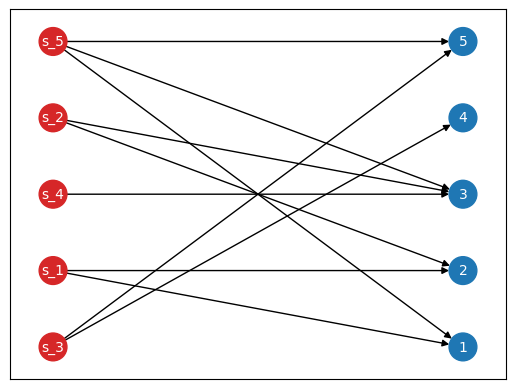

In [265]:
import networkx as nx

src_nodes = ["s_1", "s_2", "s_3", "s_4", "s_5"]  # s_1 -- s_4
dst_nodes = [1, 2, 3, 4, 5]  # entries of S

src_nodes_with_color = [(x, {"color": "tab:red"}) for x in src_nodes]
dst_nodes_with_color = [(x, {"color": "tab:blue"}) for x in dst_nodes]

G = nx.DiGraph()
G.add_nodes_from(src_nodes_with_color, bipartite=0)
G.add_nodes_from(dst_nodes_with_color, bipartite=1)

G.add_edges_from([("s_1", 1), ("s_1", 2)])  # s_1 = (1, 2)
G.add_edges_from([("s_2", 2), ("s_2", 3)])  # s_2 = (2, 3)
G.add_edges_from([("s_3", 4), ("s_3", 5)])  # s_3 = (4, 5)
G.add_edges_from([("s_4", 3)])  # s_4 = (3)
G.add_edges_from([("s_5", 1), ("s_5", 3), ("s_5", 5)])  # s_5 = (1, 3, 5)

node_color = [node["color"] for node in G.nodes.values()]

top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
nx.draw_networkx(
    G, pos=pos, node_color=node_color, node_size=400, font_size=10, font_color="white"
)

これを二部グラフの**最大マッチング問題**として解く

In [263]:
import pandas as pd

M = nx.bipartite.biadjacency_matrix(G, row_order=src_nodes, column_order=dst_nodes).todense()
df = pd.DataFrame(data=M, index=src_nodes, columns=dst_nodes)

In [266]:
# Knuth's Algorithm X
def dfs(df):
    m = np.asarray(df)
    if m.size == 0:
        return []

    nums = np.sum(m, axis=0)
    min_col = np.argmin(nums)
    candidates = np.where(m[:, min_col] != 0)[0]
    for r in candidates:
        mask_cols = np.where(m[r, :] != 0)[0]
        mask_rows = []
        for c in mask_cols:
            rows = np.where(m[:, c] != 0)[0]
            mask_rows.append(rows)

        mask_rows = np.unique(np.concatenate(mask_rows))
        new_df = df.copy()
        new_df.drop(index=new_df.index[mask_rows], inplace=True)
        new_df.drop(columns=new_df.columns[mask_cols], inplace=True)

        next_ret = dfs(new_df)
        if isinstance(next_ret, list):
            return [df.index[r]] + next_ret

    return None


solution = sorted(dfs(df))
print("The solution for exact cover is:", solution)

The solution for exact cover is: ['s_1', 's_3', 's_4']


## 問題の抽出